# Multi-Modal Regression Model

## Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')

from tcn import TCN, compiled_tcn
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, concatenate
from sklearn.preprocessing import StandardScaler
from data_preparation import prepare_x_data, get_Y_labels, unscale_Y, reshape_Y, reshape_X

2022-05-27 22:52:18.453784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
scaler = StandardScaler()

## Data preparation

Data preparation includes: <br>
<ul>
  <li>selecting necessary features from source files</li>
  <li>creating combined dataset for the model training</li>
  <li>reshaping data for model training.</li>

In [3]:
x_train_visual = prepare_x_data('../Data/LLDs_video_openface/train',',', 5, scaler)
x_train_audio = prepare_x_data('../Data/LLDs_audio_eGeMAPS/train',';', 2, scaler)

y_train = get_Y_labels('../Data/labels_metadata.csv', 60, 164, scaler)
y_train = reshape_Y(y_train,len(x_train_visual),1,1)

In [4]:
x_test_visual = prepare_x_data('../Data/LLDs_video_openface/dev',',', 5, scaler) 
x_test_audio = prepare_x_data('../Data/LLDs_audio_eGeMAPS/dev',';', 2, scaler)

y_test = get_Y_labels('../Data/labels_metadata.csv', 0, 60, scaler)
y_test = reshape_Y(y_test,len(x_test_visual),1,1)

In [5]:
v_len_dict = {}
a_len_dict = {}

for idx, df in enumerate(x_train_visual):
    v_len_dict.update({idx:len(df)})

for idx, df in enumerate(x_train_audio):
    a_len_dict.update({idx:len(df)})

# Get sequence with highest number of rows for hyper-parameter tuning.
v_max_len = max(v_len_dict, key=v_len_dict.get)
a_max_len = max(a_len_dict, key=a_len_dict.get)

v_max_len = {v_max_len:v_len_dict.get(v_max_len)}
a_max_len = {a_max_len:a_len_dict.get(a_max_len)}

print(f'Longest seq audio: {a_max_len}')
print(f'Longest seq video: {v_max_len}')


Longest seq audio: {93: 101762}
Longest seq video: {93: 30529}


# Temporal Convolutional Neural Network

Proposed model for temporal convolutional neural network architecture for multi-modal dataset. Both data modalities are concatenated together before the last Dense layer.

In [6]:
# Define input layer.
inputA = Input(shape=(None, 465))
inputB = Input(shape=(None, 23))

# Define hidden layer.
tcn_v = TCN(
    nb_filters=213, 
    kernel_size=35, 
    dilations=(128,256,512,1024), 
    padding='causal', 
    nb_stacks=1, 
    use_batch_norm=False, 
    use_layer_norm=False, 
    use_weight_norm=False, 
    use_skip_connections=True, 
    dropout_rate=0.004, 
    return_sequences=False, 
    input_shape=(None, 465))(inputA)

tcn_a = TCN(
    nb_filters=11, 
    kernel_size=34, 
    dilations=(128,256,512,1024), 
    padding='causal',
    nb_stacks=1, 
    use_batch_norm=False, 
    use_layer_norm=False, 
    use_weight_norm=False, 
    use_skip_connections=True,
    dropout_rate=0.003, 
    return_sequences=False, 
    input_shape=(None, 23))(inputB)


# Define output layer.
# output_v = Dense(8, activation='relu')(tcn_v)
# output_a = Dense(8, activation='relu')(tcn_a)

combined_input = concatenate([tcn_v, tcn_a])

output = Dense(1, activation='linear')(combined_input)

# Define optimizer and show summary.
model = Model(inputs=[inputA, inputB], outputs=[output])
model.compile(optimizer=Adam(learning_rate=0.003), loss='mse', metrics=['mae'])
model.summary()

2022-05-27 22:53:10.840696: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-27 22:53:10.853019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-27 22:53:11.256855: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-27 22:53:11.261030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-05-27 22:53:11.261080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-27 22:53:11.292940: I tensorflow/stream_executor/plat

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 465)]  0                                            
________________________________________________________________________________________

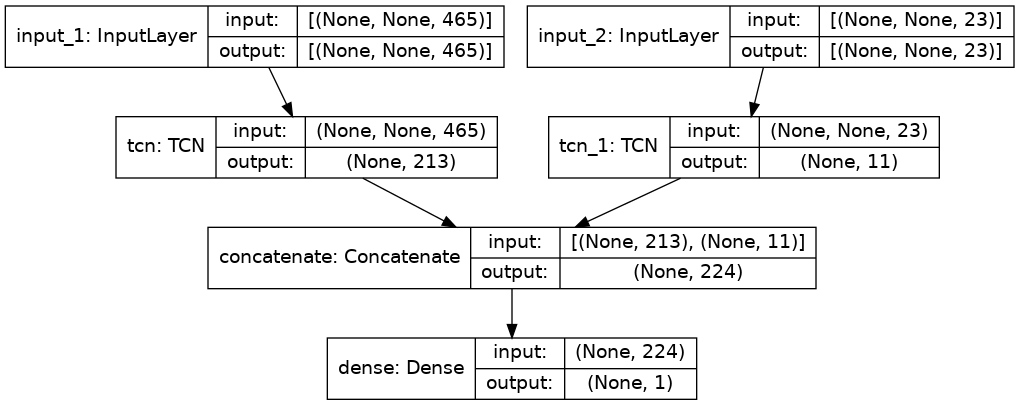

In [7]:
plot_model(model=model, show_dtype=False, show_layer_names=True, show_shapes=True, to_file='TCN_multi.png')

### Model training

Model training setup is based on an iterative approach where model is trained one file at a time, then learned parameters are saved and loaded in the next iterative step. This setup is necessary due to the fact that source files does not have an uniform size and differ in number of frames.

In [8]:
early_stop = EarlyStopping(monitor='loss', patience=10)

In [9]:
# Fit the model one file at a time.
train_index = 0
val_index = 0
loss = {}
train_eval = []
train_loss = []
train_mae = []

for train_v, train_a in zip(x_train_visual, x_train_audio):
    
    train_v = np.array(train_v).reshape((1, train_v.shape[0], -1))
    train_a = np.array(train_a).reshape((1, train_a.shape[0], -1))

    history = model.fit(x=[train_v, train_a], y=y_train[train_index], epochs=10, shuffle=False, verbose=0, callbacks=[early_stop])
    loss.update({train_index:history.history})

    train_index += 1

    # Save model
    model.save(r'TCN_Multi', include_optimizer=True)

    # Load model
    model = load_model(r'TCN_Multi', custom_objects={'TCN':TCN})

    scores = model.evaluate([train_v, train_a], y_train[val_index], verbose = 0)
    train_eval.append(scores)
    train_loss.append(scores[0])
    train_mae.append(scores[1])

    val_index += 1

2022-05-27 22:53:17.744392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-27 22:53:17.747649: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994375000 Hz
2022-05-27 22:53:22.476518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-27 22:53:23.054668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-27 22:53:24.912130: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-05-27 22:53:24.954734: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-27 22:53:41.829153: W tensorflow/python

INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


2022-05-27 23:00:22.545032: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


2022-05-27 23:02:35.138128: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-27 23:02:40.934890: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


2022-05-27 23:18:13.000422: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


2022-05-27 23:37:07.515394: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-27 23:37:11.176598: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-27 23:37:15.516330: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


2022-05-27 23:40:16.798280: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 56783940 exceeds 10% of free system memory.
2022-05-27 23:40:18.931289: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 56783940 exceeds 10% of free system memory.
2022-05-27 23:40:18.931925: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 56783940 exceeds 10% of free system memory.
2022-05-27 23:40:18.932355: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 56783940 exceeds 10% of free system memory.
2022-05-27 23:40:18.933696: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 56783940 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


INFO:tensorflow:Assets written to: TCN_Multi/assets


In [10]:
avg_train_loss = sum(train_loss) / len(train_loss)
avg_train_mae = sum(train_mae) / len(train_mae)
print("Train loss (avg):", avg_train_loss, "Train MAE (avg):", avg_train_mae)

Train loss (avg): 1.466603979829262 Train MAE (avg): 0.384991003988454


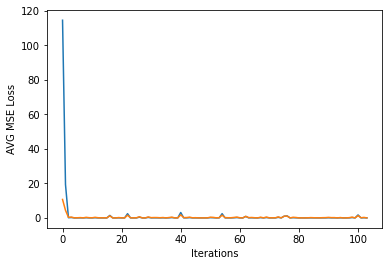

In [11]:
plt.xlabel('Iterations')
plt.ylabel('AVG MSE Loss')
plt.plot(train_loss, label='MSE')
plt.plot(train_mae, label='MAE')
plt.show()

### Model evaluation

Model evaluation is performed on subset taken from test data. 

In [12]:
x_val_visual, x_val_audio = x_test_visual[:30], x_test_audio[:30]
y_val = y_test[:30]

In [13]:
eval_loss = []
eval_mae = []
evaluation = []
index = 0

for input_visual, input_audio in zip(x_val_visual, x_val_audio):
    input_visual = reshape_X(input_visual)
    input_audio = reshape_X(input_audio)

    scores = model.evaluate(
        [input_visual,input_audio], 
        y_val[index],
        verbose = 0)

    evaluation.append(scores)    
    eval_loss.append(scores[0])
    eval_mae.append(scores[1])
    
    index += 1

In [14]:
avg_eval_loss = sum(eval_loss) / len(eval_loss)
avg_eval_mae = sum(eval_mae) / len(eval_mae)
print("Validation loss (avg):", avg_eval_loss, "Validation MAE (avg):", avg_eval_mae)

Validation loss (avg): 0.8120322402411451 Validation MAE (avg): 0.7678079639871915


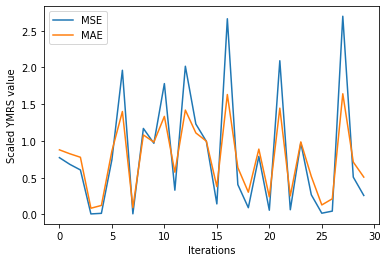

In [15]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(eval_loss, label="MSE")
plt.plot(eval_mae, label="MAE")
plt.legend()
plt.show()

### YMRS prediction and comparison

Prediction is made on different subset taken from the test dataset. Then actual and predicted YMRS values are compared.

In [16]:
x_pred_visual, x_pred_audio = x_test_visual[30:], x_test_audio[30:]
y_pred_actual = y_test[30:]

In [17]:
prediction = []
pred_eval = []
pred_loss = []
pred_mae = []
test_index = 0

for test_v, test_a in zip(x_pred_visual, x_pred_audio):
    
    test_v = np.array(test_v).reshape((1, test_v.shape[0], -1))
    test_a = np.array(test_a).reshape((1, test_a.shape[0], -1))

    pred = model.predict([test_v, test_a])
    prediction.append(pred)

    scores = model.evaluate([test_v,test_a], y_pred_actual[test_index], verbose=0)
    pred_eval.append(scores)
    pred_loss.append(scores[0])
    pred_mae.append(scores[1])

    test_index += 1


In [18]:
avg_pred_loss = sum(pred_loss) / len(pred_loss)
avg_pred_mae = sum(pred_mae) / len(pred_mae)
print("Prediction loss (avg):", avg_pred_loss, "Prediction MAE (avg):", avg_pred_mae)

Prediction loss (avg): 1.73859646390556 Prediction MAE (avg): 1.1334551726778348


In [19]:
prediction = np.array(prediction).reshape(-1, 1)
y_pred_actual = y_pred_actual.reshape(-1, 1)

In [20]:
prediction = unscale_Y(prediction, scaler)
y_pred_actual = unscale_Y(y_pred_actual, scaler)

In [21]:
pred_df = pd.DataFrame(data=np.column_stack((y_pred_actual, prediction)), columns=['y_actual','y_pred'])
pred_df['pred_error'] = pred_df['y_actual'] - pred_df['y_pred']
pred_df = pred_df.sort_values(by=['y_actual']).reset_index()
pred_df['y_actual'] = pred_df['y_actual'].apply(np.int64)
pred_df

,index,y_actual,y_pred,pred_error
0,0,0,19.113281,-19.113281
1,1,0,34.698505,-34.698505
2,27,0,23.086147,-23.086147
3,22,0,17.513725,-17.513725
4,16,0,16.895033,-16.895033
5,6,0,15.702059,-15.702059
6,10,1,15.533144,-14.533144
7,29,2,21.259075,-19.259075
8,11,3,21.780319,-18.780319
9,17,3,18.710758,-15.710758


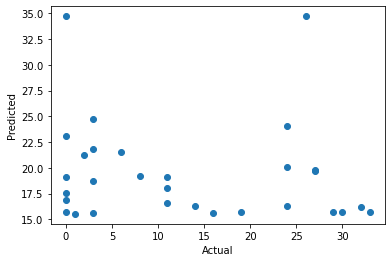

In [22]:
# Scatter plot x = actual, y = predicted
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(pred_df.y_actual, pred_df.y_pred)
plt.show()

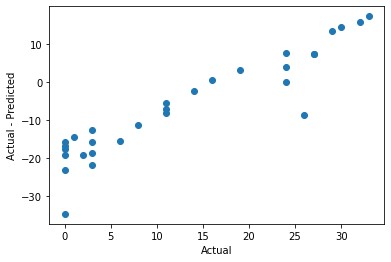

In [23]:
# Scatter plot x = actual, y = actual - predicted
plt.xlabel('Actual')
plt.ylabel('Actual - Predicted')
plt.scatter(pred_df.y_actual, pred_df.pred_error)
plt.show()

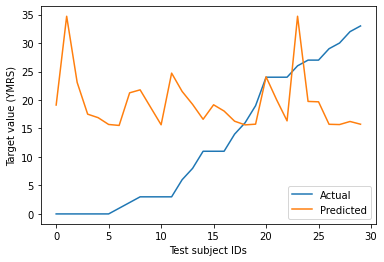

In [24]:
plt.xlabel("Test subject IDs")
plt.ylabel("Target value (YMRS)")
plt.plot(pred_df.y_actual, label="Actual")
plt.plot(pred_df.y_pred, label="Predicted")
plt.legend()
plt.show()